<a href="https://colab.research.google.com/github/pawelc666/konf_uth_git/blob/main/Konf_UTH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Instalacja wymaganych bibliotek
!pip install librosa scikit-learn joblib numpy pandas
#Importy
import os
import librosa
import numpy as np
import pandas as pd
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
#Ścieżka do folderu z nagraniami RAVDESS
base_path = "/content/drive/My Drive/rav/"
#Mapa etykiet emocji (RAVDESS)
label_mapping = {"03": "happy", "04": "sad", "05": "angry", "06": "fearful"}
#Funkcja ekstrakcji cech akustycznych
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # MFCC
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)

    # RMS Energy
    rms = np.mean(librosa.feature.rms(y=y))

    # Zero-Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))

    # Fundamental Frequency (F0)
    f0, _, _ = librosa.pyin(y, fmin=50, fmax=300, sr=sr)
    f0_mean = np.nanmean(f0) if np.any(~np.isnan(f0)) else 0  # Zamiana NaN na 0

    # Jitter (zmienność częstotliwości)
    f0 = pd.Series(f0).interpolate().bfill()
    jitter = np.mean(np.abs(np.diff(f0) / f0[:-1])) * 100 if len(f0) > 1 else 0

    # Shimmer (zmienność amplitudy)
    shimmer = np.mean(np.abs(np.diff(librosa.feature.rms(y=y)[0]) / rms)) * 100 if rms > 0 else 0

    # Spectral Centroid & Bandwidth
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

    return np.hstack([mfccs, rms, zcr, f0_mean, jitter, shimmer, spectral_centroid, spectral_bandwidth])

#Listy na dane i etykiety
data = []
labels = []

#Iteracja przez foldery aktorów
for actor_folder in os.listdir(base_path):
    actor_path = os.path.join(base_path, actor_folder)

    if os.path.isdir(actor_path):  # Sprawdzenie, czy to folder
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):  # Sprawdzenie, czy to plik audio
                file_path = os.path.join(actor_path, file)

                # Pobranie etykiety emocji
                emotion_label = file.split("-")[2]  # Trzeci element w nazwie pliku
                label = label_mapping.get(emotion_label, "unknown")

                if label != "unknown":  # Tylko znane emocje
                    features = extract_features(file_path)
                    data.append(features)
                    labels.append(label)

# 📌 Konwersja list do numpy array
data = np.array(data)
labels = np.array(labels)

print(f"🔹 Znaleziono {len(data)} próbek audio.")

# 📌 Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# 📌 Tworzenie i trenowanie modelu SVM
svm_model = make_pipeline(StandardScaler(), SVC(kernel="linear", probability=True))
svm_model.fit(X_train, y_train)

# 📌 Zapis modelu do pliku
joblib.dump(svm_model, "/content/svm_emotion_model.pkl")

print("✅ Model został zapisany!")

# 📌 Testowanie modelu na nowym pliku
test_file = "/content/drive/My Drive/rav/Actor_01/03-01-05-02-01-01-01.wav"
test_features = extract_features(test_file)

# 📌 Wczytanie modelu i predykcja emocji
loaded_model = joblib.load("/content/svm_emotion_model.pkl")
predicted_emotion = loaded_model.predict([test_features])[0]

print(f"🎭 Rozpoznana emocja: {predicted_emotion}")


🔹 Znaleziono 768 próbek audio.
✅ Model został zapisany!
🎭 Rozpoznana emocja: angry


In [ ]:
from sklearn.metrics import accuracy_score

# 📌 Predykcje na zbiorze testowym
y_pred = svm_model.predict(X_test)

# 📌 Obliczenie dokładności (val accuracy)
val_accuracy = accuracy_score(y_test, y_pred)

print(f"📊 Validation Accuracy: {val_accuracy:.4f}")


📊 Validation Accuracy: 0.7468


Accuracy: 0.7468

Classification Report:
               precision    recall  f1-score   support

       angry       0.80      0.80      0.80        41
     fearful       0.65      0.81      0.72        37
       happy       0.79      0.58      0.67        38
         sad       0.77      0.79      0.78        38

    accuracy                           0.75       154
   macro avg       0.75      0.75      0.74       154
weighted avg       0.75      0.75      0.74       154



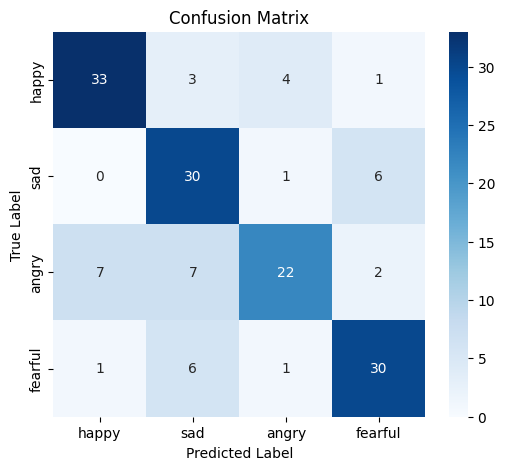

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Predykcje na zbiorze testowym
y_pred = svm_model.predict(X_test)

# Obliczenie dokładności
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Raport klasyfikacji
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Macierz błędów
conf_matrix = confusion_matrix(y_test, y_pred)

# Wizualizacja macierzy błędów
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# 📌 Instalacja wymaganych bibliotek
!pip install librosa scikit-learn joblib numpy pandas

# 📌 Importy
import os
import librosa
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# 📌 Ścieżka do folderu z nagraniami RAVDESS
base_path = "/content/drive/My Drive/rav/"

# 📌 Mapa etykiet emocji (RAVDESS)
label_mapping = {"03": "happy", "04": "sad", "05": "angry", "06": "fearful"}

# 📌 Funkcja ekstrakcji cech akustycznych
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # MFCC
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)

    # RMS Energy
    rms = np.mean(librosa.feature.rms(y=y))

    # Zero-Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))

    # Fundamental Frequency (F0)
    f0, _, _ = librosa.pyin(y, fmin=50, fmax=300, sr=sr)
    f0_mean = np.nanmean(f0) if np.any(~np.isnan(f0)) else 0  # Zamiana NaN na 0

    # Jitter (zmienność częstotliwości)
    f0 = pd.Series(f0).interpolate().bfill()
    jitter = np.mean(np.abs(np.diff(f0) / f0[:-1])) * 100 if len(f0) > 1 else 0

    # Shimmer (zmienność amplitudy)
    shimmer = np.mean(np.abs(np.diff(librosa.feature.rms(y=y)[0]) / rms)) * 100 if rms > 0 else 0

    # Spectral Centroid & Bandwidth
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

    return np.hstack([mfccs, rms, zcr, f0_mean, jitter, shimmer, spectral_centroid, spectral_bandwidth])

# 📌 Listy na dane i etykiety
data = []
labels = []

# 📌 Iteracja przez foldery aktorów
for actor_folder in os.listdir(base_path):
    actor_path = os.path.join(base_path, actor_folder)

    if os.path.isdir(actor_path):  # Sprawdzenie, czy to folder
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):  # Sprawdzenie, czy to plik audio
                file_path = os.path.join(actor_path, file)

                # Pobranie etykiety emocji
                emotion_label = file.split("-")[2]  # Trzeci element w nazwie pliku
                label = label_mapping.get(emotion_label, "unknown")

                if label != "unknown":  # Tylko znane emocje
                    features = extract_features(file_path)
                    data.append(features)
                    labels.append(label)

# 📌 Konwersja list do numpy array
data = np.array(data)
labels = np.array(labels)

print(f"🔹 Znaleziono {len(data)} próbek audio.")

# 📌 Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# 📌 Tworzenie i trenowanie modelu Random Forest
rf_model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))
rf_model.fit(X_train, y_train)

# 📌 Zapis modelu do pliku
joblib.dump(rf_model, "/content/random_forest_emotion_model.pkl")

print("✅ Model Random Forest został zapisany!")

# 📌 Testowanie modelu na nowym pliku
test_file = "/content/drive/My Drive/rav/Actor_01/03-01-05-02-01-01-01.wav"
test_features = extract_features(test_file)

# 📌 Wczytanie modelu i predykcja emocji
loaded_rf_model = joblib.load("/content/random_forest_emotion_model.pkl")
predicted_emotion = loaded_rf_model.predict([test_features])[0]

print(f"🎭 Rozpoznana emocja (Random Forest): {predicted_emotion}")


🔹 Znaleziono 768 próbek audio.
✅ Model Random Forest został zapisany!
🎭 Rozpoznana emocja (Random Forest): angry


🔹 Accuracy: 0.7013

🔹 Classification Report:
               precision    recall  f1-score   support

       angry       0.85      0.85      0.85        41
     fearful       0.59      0.62      0.61        37
       happy       0.68      0.55      0.61        38
         sad       0.67      0.76      0.72        38

    accuracy                           0.70       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.70      0.70      0.70       154



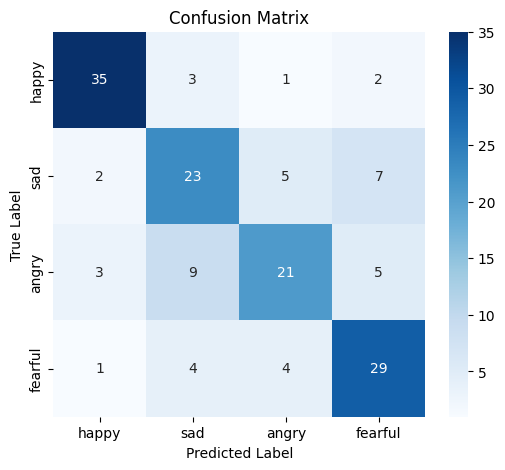

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predykcje na zbiorze testowym
y_pred = rf_model.predict(X_test)

# 🔹 Accuracy (dokładność)
accuracy = accuracy_score(y_test, y_pred)
print(f"🔹 Accuracy: {accuracy:.4f}")

# 🔹 Precision, Recall, F1-score
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# 🔹 Macierz błędów
conf_matrix = confusion_matrix(y_test, y_pred)

# Wizualizacja macierzy błędów
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# 📌 Tworzenie i trenowanie modelu Random Forest
rf_model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))
rf_model.fit(X_train, y_train)

# 📌 Predykcje na zbiorze testowym
y_pred = rf_model.predict(X_test)

# 📌 Obliczenie dokładności (val accuracy)
val_accuracy = accuracy_score(y_test, y_pred)
print(f"📊 Validation Accuracy: {val_accuracy:.4f}")

# 📌 Zapis modelu do pliku
joblib.dump(rf_model, "/content/random_forest_emotion_model.pkl")

print("✅ Model Random Forest został zapisany!")

# 📌 Testowanie modelu na nowym pliku
test_file = "/content/drive/My Drive/rav/Actor_01/03-01-05-02-01-01-01.wav"
test_features = extract_features(test_file)

# 📌 Wczytanie modelu i predykcja emocji
loaded_rf_model = joblib.load("/content/random_forest_emotion_model.pkl")
predicted_emotion = loaded_rf_model.predict([test_features])[0]

print(f"🎭 Rozpoznana emocja (Random Forest): {predicted_emotion}")



📊 Validation Accuracy: 0.7013
✅ Model Random Forest został zapisany!
🎭 Rozpoznana emocja (Random Forest): angry


🔹 Znaleziono 768 próbek audio.
🔹 Accuracy: 0.6948

🔹 Classification Report:
               precision    recall  f1-score   support

       angry       0.82      0.80      0.81        41
     fearful       0.56      0.49      0.52        37
       happy       0.71      0.58      0.64        38
         sad       0.67      0.89      0.76        38

    accuracy                           0.69       154
   macro avg       0.69      0.69      0.68       154
weighted avg       0.69      0.69      0.69       154



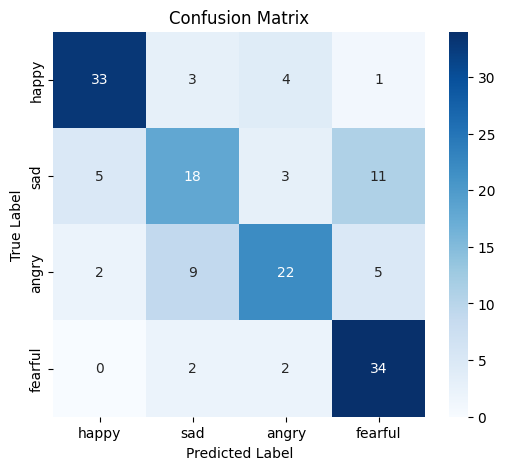

In [ ]:
# 📌 Instalacja wymaganych bibliotek
!pip install librosa scikit-learn joblib numpy pandas xgboost

# 📌 Importy
import os
import librosa
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Ścieżka do folderu z nagraniami RAVDESS
base_path = "/content/drive/My Drive/rav/"

# 📌 Mapa etykiet emocji (RAVDESS)
label_mapping = {"03": "happy", "04": "sad", "05": "angry", "06": "fearful"}

# 📌 Funkcja ekstrakcji cech akustycznych
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # MFCC
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)

    # RMS Energy
    rms = np.mean(librosa.feature.rms(y=y))

    # Zero-Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))

    # Fundamental Frequency (F0)
    f0, _, _ = librosa.pyin(y, fmin=50, fmax=300, sr=sr)
    f0_mean = np.nanmean(f0) if np.any(~np.isnan(f0)) else 0  # Zamiana NaN na 0

    # Jitter (zmienność częstotliwości)
    f0 = pd.Series(f0).interpolate().bfill()
    jitter = np.mean(np.abs(np.diff(f0) / f0[:-1])) * 100 if len(f0) > 1 else 0

    # Shimmer (zmienność amplitudy)
    shimmer = np.mean(np.abs(np.diff(librosa.feature.rms(y=y)[0]) / rms)) * 100 if rms > 0 else 0

    # Spectral Centroid & Bandwidth
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

    return np.hstack([mfccs, rms, zcr, f0_mean, jitter, shimmer, spectral_centroid, spectral_bandwidth])

# 📌 Listy na dane i etykiety
data = []
labels = []

# 📌 Iteracja przez foldery aktorów
for actor_folder in os.listdir(base_path):
    actor_path = os.path.join(base_path, actor_folder)

    if os.path.isdir(actor_path):  # Sprawdzenie, czy to folder
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):  # Sprawdzenie, czy to plik audio
                file_path = os.path.join(actor_path, file)

                # Pobranie etykiety emocji
                emotion_label = file.split("-")[2]  # Trzeci element w nazwie pliku
                label = label_mapping.get(emotion_label, "unknown")

                if label != "unknown":  # Tylko znane emocje
                    features = extract_features(file_path)
                    data.append(features)
                    labels.append(label)

# 📌 Konwersja list do numpy array
data = np.array(data)
labels = np.array(labels)

print(f"🔹 Znaleziono {len(data)} próbek audio.")

# 📌 Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# 📌 Konwersja etykiet do formatu numerycznego
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 📌 Model XGBoost
xgboost_model = xgb.XGBClassifier(
    objective="multi:softmax",  # wieloklasowa klasyfikacja
    num_class=len(label_mapping),  # Liczba klas emocji
    eval_metric="mlogloss",  # Funkcja oceny dla wielu klas
    random_state=42
)

# Trening modelu
xgboost_model.fit(X_train, y_train_encoded)

# 📌 Predykcje na zbiorze testowym
y_pred_encoded = xgboost_model.predict(X_test)

# 📌 Dekodowanie etykiet
y_pred = le.inverse_transform(y_pred_encoded)
y_test_decoded = le.inverse_transform(y_test_encoded)

# 🔹 Accuracy (dokładność)
accuracy = accuracy_score(y_test_decoded, y_pred)
print(f"🔹 Accuracy: {accuracy:.4f}")

# 🔹 Precision, Recall, F1-score
print("\n🔹 Classification Report:\n", classification_report(y_test_decoded, y_pred))

# 🔹 Macierz błędów
conf_matrix = confusion_matrix(y_test_decoded, y_pred)

# Wizualizacja macierzy błędów
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


🔹 Znaleziono 768 próbek audio.
🔹 Accuracy: 0.7013

🔹 Classification Report:
               precision    recall  f1-score   support

       angry       0.89      0.80      0.85        41
     fearful       0.57      0.68      0.62        37
       happy       0.68      0.55      0.61        38
         sad       0.69      0.76      0.72        38

    accuracy                           0.70       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.71      0.70      0.70       154



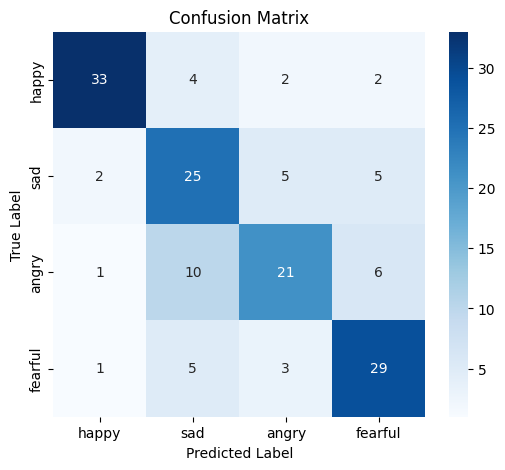

In [ ]:
# 📌 Instalacja wymaganych bibliotek
!pip install librosa scikit-learn joblib numpy pandas

# 📌 Importy
import os
import librosa
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Ścieżka do folderu z nagraniami RAVDESS
base_path = "/content/drive/My Drive/rav/"

# 📌 Mapa etykiet emocji (RAVDESS)
label_mapping = {"03": "happy", "04": "sad", "05": "angry", "06": "fearful"}

# 📌 Funkcja ekstrakcji cech akustycznych
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # MFCC
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)

    # RMS Energy
    rms = np.mean(librosa.feature.rms(y=y))

    # Zero-Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))

    # Fundamental Frequency (F0)
    f0, _, _ = librosa.pyin(y, fmin=50, fmax=300, sr=sr)
    f0_mean = np.nanmean(f0) if np.any(~np.isnan(f0)) else 0  # Zamiana NaN na 0

    # Jitter (zmienność częstotliwości)
    f0 = pd.Series(f0).interpolate().bfill()
    jitter = np.mean(np.abs(np.diff(f0) / f0[:-1])) * 100 if len(f0) > 1 else 0

    # Shimmer (zmienność amplitudy)
    shimmer = np.mean(np.abs(np.diff(librosa.feature.rms(y=y)[0]) / rms)) * 100 if rms > 0 else 0

    # Spectral Centroid & Bandwidth
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

    return np.hstack([mfccs, rms, zcr, f0_mean, jitter, shimmer, spectral_centroid, spectral_bandwidth])

# 📌 Listy na dane i etykiety
data = []
labels = []

# 📌 Iteracja przez foldery aktorów
for actor_folder in os.listdir(base_path):
    actor_path = os.path.join(base_path, actor_folder)

    if os.path.isdir(actor_path):  # Sprawdzenie, czy to folder
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):  # Sprawdzenie, czy to plik audio
                file_path = os.path.join(actor_path, file)

                # Pobranie etykiety emocji
                emotion_label = file.split("-")[2]  # Trzeci element w nazwie pliku
                label = label_mapping.get(emotion_label, "unknown")

                if label != "unknown":  # Tylko znane emocje
                    features = extract_features(file_path)
                    data.append(features)
                    labels.append(label)

# 📌 Konwersja list do numpy array
data = np.array(data)
labels = np.array(labels)

print(f"🔹 Znaleziono {len(data)} próbek audio.")

# 📌 Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# 📌 Konwersja etykiet do formatu numerycznego
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 📌 Model SVM z kernelem RBF
svm_model = SVC(kernel='rbf', random_state=42)

# 🔹 Skalowanie cech (przed treningiem modelu SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Trening modelu
svm_model.fit(X_train_scaled, y_train_encoded)

# 📌 Predykcje na zbiorze testowym
y_pred_encoded = svm_model.predict(X_test_scaled)

# 📌 Dekodowanie etykiet
y_pred = le.inverse_transform(y_pred_encoded)
y_test_decoded = le.inverse_transform(y_test_encoded)

# 🔹 Accuracy (dokładność)
accuracy = accuracy_score(y_test_decoded, y_pred)
print(f"🔹 Accuracy: {accuracy:.4f}")

# 🔹 Precision, Recall, F1-score
print("\n🔹 Classification Report:\n", classification_report(y_test_decoded, y_pred))

# 🔹 Macierz błędów
conf_matrix = confusion_matrix(y_test_decoded, y_pred)

# Wizualizacja macierzy błędów
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


🔹 Znaleziono 768 próbek audio.
🔹 Accuracy: 0.6818

🔹 Classification Report:
               precision    recall  f1-score   support

       angry       0.82      0.68      0.75        41
     fearful       0.66      0.62      0.64        37
       happy       0.55      0.76      0.64        38
         sad       0.78      0.66      0.71        38

    accuracy                           0.68       154
   macro avg       0.70      0.68      0.68       154
weighted avg       0.70      0.68      0.69       154



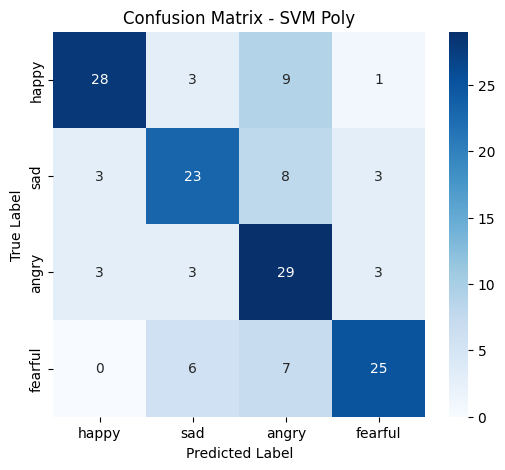

In [ ]:
# 📌 Instalacja wymaganych bibliotek
!pip install librosa scikit-learn joblib numpy pandas

# 📌 Importy
import os
import librosa
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 📌 Ścieżka do folderu z nagraniami RAVDESS
base_path = "/content/drive/My Drive/rav/"

# 📌 Mapa etykiet emocji (RAVDESS)
label_mapping = {"03": "happy", "04": "sad", "05": "angry", "06": "fearful"}

# 📌 Funkcja ekstrakcji cech akustycznych
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # MFCC
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)

    # RMS Energy
    rms = np.mean(librosa.feature.rms(y=y))

    # Zero-Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))

    # Fundamental Frequency (F0)
    f0, _, _ = librosa.pyin(y, fmin=50, fmax=300, sr=sr)
    f0_mean = np.nanmean(f0) if np.any(~np.isnan(f0)) else 0  # Zamiana NaN na 0

    # Jitter (zmienność częstotliwości)
    f0 = pd.Series(f0).interpolate().bfill()
    jitter = np.mean(np.abs(np.diff(f0) / f0[:-1])) * 100 if len(f0) > 1 else 0

    # Shimmer (zmienność amplitudy)
    shimmer = np.mean(np.abs(np.diff(librosa.feature.rms(y=y)[0]) / rms)) * 100 if rms > 0 else 0

    # Spectral Centroid & Bandwidth
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

    return np.hstack([mfccs, rms, zcr, f0_mean, jitter, shimmer, spectral_centroid, spectral_bandwidth])

# 📌 Listy na dane i etykiety
data = []
labels = []

# 📌 Iteracja przez foldery aktorów
for actor_folder in os.listdir(base_path):
    actor_path = os.path.join(base_path, actor_folder)

    if os.path.isdir(actor_path):  # Sprawdzenie, czy to folder
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):  # Sprawdzenie, czy to plik audio
                file_path = os.path.join(actor_path, file)

                # Pobranie etykiety emocji
                emotion_label = file.split("-")[2]  # Trzeci element w nazwie pliku
                label = label_mapping.get(emotion_label, "unknown")

                if label != "unknown":  # Tylko znane emocje
                    features = extract_features(file_path)
                    data.append(features)
                    labels.append(label)

# 📌 Konwersja list do numpy array
data = np.array(data)
labels = np.array(labels)

print(f"🔹 Znaleziono {len(data)} próbek audio.")

# 📌 Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# 📌 Konwersja etykiet do formatu numerycznego
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 📌 Skalowanie cech (niezbędne dla SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 📌 Model SVM z jądrem wielomianowym (poly)
svm_poly_model = SVC(kernel='poly', degree=3, C=1, random_state=42)  # degree=3 oznacza wielomian stopnia 3

# 📌 Trenowanie modelu
svm_poly_model.fit(X_train_scaled, y_train_encoded)

# 📌 Predykcja na zbiorze testowym
y_pred_encoded = svm_poly_model.predict(X_test_scaled)

# 📌 Dekodowanie etykiet
y_pred = le.inverse_transform(y_pred_encoded)
y_test_decoded = le.inverse_transform(y_test_encoded)

# 🔹 Accuracy (dokładność)
accuracy = accuracy_score(y_test_decoded, y_pred)
print(f"🔹 Accuracy: {accuracy:.4f}")

# 🔹 Precision, Recall, F1-score
print("\n🔹 Classification Report:\n", classification_report(y_test_decoded, y_pred))

# 🔹 Macierz błędów
conf_matrix = confusion_matrix(y_test_decoded, y_pred)

# 📌 Wizualizacja macierzy błędów
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM Poly")
plt.show()


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 📌 Testowanie różnych stopni wielomianu
best_degree = None
best_accuracy = 0
results = {}

for degree in [2, 3, 4, 5]:
    # Tworzenie i trenowanie modelu SVM z danym stopniem wielomianu
    svm_poly_model = SVC(kernel='poly', degree=degree, C=1, random_state=42)
    svm_poly_model.fit(X_train_scaled, y_train_encoded)

    # Predykcja i ocena dokładności
    y_pred_encoded = svm_poly_model.predict(X_test_scaled)
    y_pred = le.inverse_transform(y_pred_encoded)
    accuracy = accuracy_score(y_test_decoded, y_pred)

    results[degree] = accuracy
    print(f"🔹 Stopień {degree} - Accuracy: {accuracy:.4f}")

    # Aktualizacja najlepszego modelu
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_degree = degree

print(f"\n✅ Najlepszy stopień wielomianu: {best_degree} (Accuracy: {best_accuracy:.4f})")

# 📌 Trening finalnego modelu z najlepszym stopniem
final_svm_poly = SVC(kernel='poly', degree=best_degree, C=1, random_state=42)
final_svm_poly.fit(X_train_scaled, y_train_encoded)

# 📌 Zapis najlepszego modelu
joblib.dump(final_svm_poly, f"/content/svm_poly_best_degree_{best_degree}.pkl")
print(f"✅ Model SVM (poly, degree={best_degree}) zapisany!")


🔹 Stopień 2 - Accuracy: 0.5649
🔹 Stopień 3 - Accuracy: 0.6818
🔹 Stopień 4 - Accuracy: 0.5000
🔹 Stopień 5 - Accuracy: 0.4675

✅ Najlepszy stopień wielomianu: 3 (Accuracy: 0.6818)
✅ Model SVM (poly, degree=3) zapisany!


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# 📌 Definiujemy siatkę hyperparametrów
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularizacja
    'degree': [2, 3, 4, 5]   # Stopień wielomianu
}

# 📌 Tworzenie modelu SVM z jądrem wielomianowym
svm_poly = SVC(kernel='poly', random_state=42)

# 📌 GridSearchCV – przeszukiwanie najlepszych parametrów
grid_search = GridSearchCV(svm_poly, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_encoded)

# 📌 Najlepsze parametry
best_C = grid_search.best_params_['C']
best_degree = grid_search.best_params_['degree']
best_accuracy = grid_search.best_score_

print(f"✅ Najlepsze C: {best_C}, Najlepszy stopień: {best_degree}, Accuracy: {best_accuracy:.4f}")

# 📌 Trening finalnego modelu z najlepszymi parametrami
final_svm_poly = SVC(kernel='poly', C=best_C, degree=best_degree, random_state=42)
final_svm_poly.fit(X_train_scaled, y_train_encoded)

# 📌 Zapis najlepszego modelu
joblib.dump(final_svm_poly, f"/content/svm_poly_best_C{best_C}_degree{best_degree}.pkl")
print(f"✅ Model SVM (poly, C={best_C}, degree={best_degree}) zapisany!")


✅ Najlepsze C: 10, Najlepszy stopień: 3, Accuracy: 0.6287
✅ Model SVM (poly, C=10, degree=3) zapisany!


In [ ]:
# 📌 Instalacja wymaganych bibliotek
!pip install librosa tensorflow scikit-learn numpy pandas

# 📌 Importy
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 📌 Ścieżka do folderu z nagraniami RAVDESS
base_path = "/content/drive/My Drive/rav/"

# 📌 Mapa etykiet emocji
label_mapping = {"03": "happy", "04": "sad", "05": "angry", "06": "fearful"}

# 📌 Funkcja ekstrakcji cech (MFCC + inne parametry)
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # RMS Energy
    rms = librosa.feature.rms(y=y)

    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)

    # Fundamental Frequency (F0)
    f0, _, _ = librosa.pyin(y, fmin=50, fmax=300, sr=sr)
    f0 = np.nan_to_num(f0)  # Zamiana NaN na 0

    # Konwersja do tego samego kształtu (pad lub crop)
    max_len = 200  # Stała długość próbek
    features = np.vstack([mfccs, rms, zcr, f0])

    if features.shape[1] < max_len:
        pad_width = max_len - features.shape[1]
        features = np.pad(features, ((0, 0), (0, pad_width)), mode="constant")
    else:
        features = features[:, :max_len]

    return features.T  # Transpozycja, by mieć sekwencje czasowe

# 📌 Listy na dane i etykiety
data = []
labels = []

# 📌 Iteracja przez foldery aktorów
for actor_folder in os.listdir(base_path):
    actor_path = os.path.join(base_path, actor_folder)

    if os.path.isdir(actor_path):  # Sprawdzenie, czy to folder
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):  # Sprawdzenie, czy to plik audio
                file_path = os.path.join(actor_path, file)

                # Pobranie etykiety emocji
                emotion_label = file.split("-")[2]
                label = label_mapping.get(emotion_label, "unknown")

                if label != "unknown":  # Tylko znane emocje
                    features = extract_features(file_path)
                    data.append(features)
                    labels.append(label)

# 📌 Konwersja list do numpy array
data = np.array(data)
labels = np.array(labels)

print(f"🔹 Znaleziono {len(data)} próbek audio.")

# 📌 Kodowanie etykiet
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_categorical = to_categorical(y_encoded)

# 📌 Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(data, y_categorical, test_size=0.2, random_state=42)

# 📌 Definicja modelu LSTM
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(y_train.shape[1], activation='softmax')  # Wyjście z liczbą klas
])

# 📌 Kompilacja modelu
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 📌 Trenowanie modelu
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

# 📌 Zapis modelu
model.save("/content/lstm_emotion_model.h5")
print("✅ Model LSTM został zapisany!")


🔹 Znaleziono 768 próbek audio.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.2977 - loss: 1.7433 - val_accuracy: 0.4416 - val_loss: 1.3087
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.4158 - loss: 1.3924 - val_accuracy: 0.4286 - val_loss: 1.2686
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 276ms/step - accuracy: 0.4569 - loss: 1.2156 - val_accuracy: 0.4545 - val_loss: 1.2464
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step - accuracy: 0.4565 - loss: 1.2196 - val_accuracy: 0.4416 - val_loss: 1.2021
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.5044 - loss: 1.1318 - val_accuracy: 0.5065 - val_loss: 1.1487
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 276ms/step - accuracy: 0.5475 - loss: 1.0951 - val_accuracy: 0.4740 - val_loss: 1.1876
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 274ms/step - accuracy: 0.5137 - loss: 1.1243 - val_accuracy: 0.5325 - val_loss: 1.0319
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.5677 - loss: 1.0532 - val_accura

✅ Model LSTM został zapisany!


In [ ]:
# 📌 Instalacja wymaganych bibliotek
!pip install librosa tensorflow scikit-learn numpy pandas

# 📌 Importy
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 📌 Ścieżka do folderu z nagraniami RAVDESS
base_path = "/content/drive/My Drive/rav/"

# 📌 Mapa etykiet emocji
label_mapping = {"03": "happy", "04": "sad", "05": "angry", "06": "fearful"}

# 📌 Funkcja ekstrakcji cech (MFCC + inne parametry)
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # RMS Energy
    rms = librosa.feature.rms(y=y)

    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)

    # Fundamental Frequency (F0)
    f0, _, _ = librosa.pyin(y, fmin=50, fmax=300, sr=sr)
    f0 = np.nan_to_num(f0)  # Zamiana NaN na 0

    # Konwersja do tego samego kształtu (pad lub crop)
    max_len = 200  # Stała długość próbek
    features = np.vstack([mfccs, rms, zcr, f0])

    if features.shape[1] < max_len:
        pad_width = max_len - features.shape[1]
        features = np.pad(features, ((0, 0), (0, pad_width)), mode="constant")
    else:
        features = features[:, :max_len]

    return features.T  # Transpozycja, by mieć sekwencje czasowe

# 📌 Listy na dane i etykiety
data = []
labels = []

# 📌 Iteracja przez foldery aktorów
for actor_folder in os.listdir(base_path):
    actor_path = os.path.join(base_path, actor_folder)

    if os.path.isdir(actor_path):  # Sprawdzenie, czy to folder
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):  # Sprawdzenie, czy to plik audio
                file_path = os.path.join(actor_path, file)

                # Pobranie etykiety emocji
                emotion_label = file.split("-")[2]
                label = label_mapping.get(emotion_label, "unknown")

                if label != "unknown":  # Tylko znane emocje
                    features = extract_features(file_path)
                    data.append(features)
                    labels.append(label)

# 📌 Konwersja list do numpy array
data = np.array(data)
labels = np.array(labels)

print(f"🔹 Znaleziono {len(data)} próbek audio.")

# 📌 Kodowanie etykiet
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_categorical = to_categorical(y_encoded)

# 📌 Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(data, y_categorical, test_size=0.2, random_state=42)

# 📌 Definicja modelu LSTM
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(y_train.shape[1], activation='softmax')  # Wyjście z liczbą klas
])

# 📌 Kompilacja modelu
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 📌 Trenowanie modelu
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

# 📌 Zapis modelu
model.save("/content/lstm_emotion_model.h5")
print("✅ Model LSTM został zapisany!")


🔹 Znaleziono 768 próbek audio.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 272ms/step - accuracy: 0.2909 - loss: 1.8723 - val_accuracy: 0.4156 - val_loss: 1.3338
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 238ms/step - accuracy: 0.3951 - loss: 1.4097 - val_accuracy: 0.4675 - val_loss: 1.3039
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.4275 - loss: 1.3388 - val_accuracy: 0.4675 - val_loss: 1.2484
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.4899 - loss: 1.2619 - val_accuracy: 0.4416 - val_loss: 1.2325
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.4377 - loss: 1.2323 - val_accuracy: 0.4870 - val_loss: 1.1523
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - accuracy: 0.4707 - loss: 1.1965 - val_accuracy: 0.4870 - val_loss: 1.1601
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.4740 - loss: 1.1938 - val_accuracy: 0.5649 - val_loss: 1.0945
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.5101 - loss: 1.1737 - val_accuracy: 0.4675 -

✅ Model LSTM został zapisany!


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
              precision    recall  f1-score   support

       angry       0.93      0.68      0.79        41
     fearful       0.48      0.54      0.51        37
       happy       0.63      0.50      0.56        38
         sad       0.62      0.84      0.71        38

    accuracy                           0.64       154
   macro avg       0.66      0.64      0.64       154
weighted avg       0.67      0.64      0.64       154



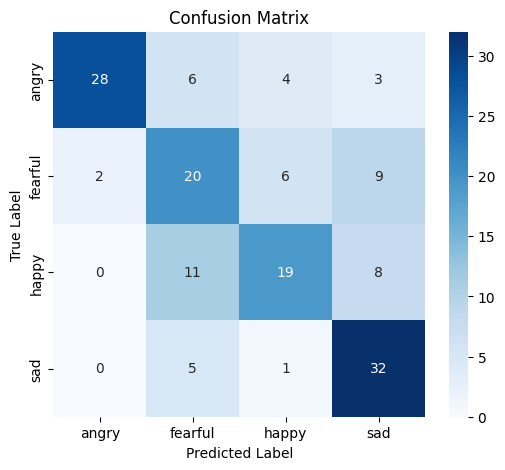

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Predykcja na zbiorze testowym
y_pred_probs = model.predict(X_test)  # Prawdopodobieństwa klas
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Najbardziej prawdopodobna klasa

# 📌 Upewnienie się, że y_test jest w odpowiednim formacie
if y_test.ndim == 2:  # Jeśli one-hot encoding
    y_true_classes = np.argmax(y_test, axis=1)  # Konwersja do klas
else:
    y_true_classes = y_test  # Jeśli już są klasy, zostawiamy bez zmian

# 📌 Metryki klasyfikacji
report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=1)
print(report)

# 📌 Macierz błędów
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# 📌 Wizualizacja macierzy błędów
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
# 📌 Instalacja wymaganych bibliotek
!pip install librosa tensorflow scikit-learn joblib numpy pandas

# 📌 Importy
import os
import librosa
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# 📌 Ścieżka do folderu z nagraniami RAVDESS
base_path = "/content/drive/My Drive/rav/"

# 📌 Mapa etykiet emocji (RAVDESS)
label_mapping = {"03": "happy", "04": "sad", "05": "angry", "06": "fearful"}

# 📌 Funkcja ekstrakcji cech akustycznych - Mel Spectrogram
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Zmieniamy rozmiar, by uzyskać jednorodne dane wejściowe
    mel_spec_resized = librosa.util.fix_length(mel_spec, size=128, axis=-1)

    return mel_spec_resized

# 📌 Listy na dane i etykiety
data = []
labels = []

# 📌 Iteracja przez foldery aktorów
for actor_folder in os.listdir(base_path):
    actor_path = os.path.join(base_path, actor_folder)

    if os.path.isdir(actor_path):  # Sprawdzenie, czy to folder
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):  # Sprawdzenie, czy to plik audio
                file_path = os.path.join(actor_path, file)

                # Pobranie etykiety emocji
                emotion_label = file.split("-")[2]  # Trzeci element w nazwie pliku
                label = label_mapping.get(emotion_label, "unknown")

                if label != "unknown":  # Tylko znane emocje
                    features = extract_features(file_path)
                    data.append(features)
                    labels.append(label)

# 📌 Konwersja list do numpy array
data = np.array(data)
labels = np.array(labels)

print(f"🔹 Znaleziono {len(data)} próbek audio.")

# 📌 Kodowanie etykiet
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_categorical = to_categorical(y_encoded)

# 📌 Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(data, y_categorical, test_size=0.2, random_state=42)

# 📌 Zmiana kształtu danych wejściowych, aby pasowały do modelu CNN (dodajemy kanał)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# 📌 Definicja modelu CNN
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

# 📌 Kompilacja modelu
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 📌 Trenowanie modelu
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

# 📌 Zapis modelu
model.save("/content/cnn_emotion_model.h5")
print("✅ Model CNN został zapisany!")

# 📌 Ocena modelu na zbiorze testowym
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"📊 Test Accuracy: {test_accuracy:.4f}")

# 📌 Testowanie modelu na nowym pliku
test_file = "/content/drive/My Drive/rav/Actor_01/03-01-05-02-01-01-01.wav"
test_features = extract_features(test_file)

# 📌 Zmieniamy kształt danych wejściowych
test_features_resized = test_features[np.newaxis, ..., np.newaxis]

# 📌 Wczytanie modelu i predykcja emocji
predicted_emotion = model.predict(test_features_resized)
predicted_label = label_encoder.inverse_transform(np.argmax(predicted_emotion, axis=1))

print(f"🎭 Rozpoznana emocja (CNN): {predicted_label[0]}")


🔹 Znaleziono 768 próbek audio.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 583ms/step - accuracy: 0.2094 - loss: 62.8705 - val_accuracy: 0.2468 - val_loss: 1.3864
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 484ms/step - accuracy: 0.2434 - loss: 1.3973 - val_accuracy: 0.2468 - val_loss: 1.3866
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 562ms/step - accuracy: 0.2048 - loss: 1.3893 - val_accuracy: 0.2403 - val_loss: 1.3866
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 478ms/step - accuracy: 0.2542 - loss: 1.3859 - val_accuracy: 0.2403 - val_loss: 1.3865
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 508ms/step - accuracy: 0.2540 - loss: 1.3861 - val_accuracy: 0.2403 - val_loss: 1.3865
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 488ms/step - accuracy: 0.2217 - loss: 1.3867 - val_accuracy: 0.2403 - val_loss: 1.3863
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 488ms/step - accuracy: 0.2424 - loss: 1.3844 - val_accuracy: 0.2468 - val_loss: 1.3867
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.2615 - loss: 1.3915 - val_acc

✅ Model CNN został zapisany!
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.2428 - loss: 1.3871
📊 Test Accuracy: 0.2468
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
🎭 Rozpoznana emocja (CNN): happy


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 502ms/step - accuracy: 0.2449 - loss: 5118678.0000 - val_accuracy: 0.2403 - val_loss: 1.3864
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 448ms/step - accuracy: 0.2441 - loss: 2.9605 - val_accuracy: 0.2403 - val_loss: 1.3863
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - accuracy: 0.2560 - loss: 1.3860 - val_accuracy: 0.2468 - val_loss: 1.3864
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.2213 - loss: 1.3869 - val_accuracy: 0.2403 - val_loss: 1.3865
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 440ms/step - accuracy: 0.2739 - loss: 1.3858 - val_accuracy: 0.2468 - val_loss: 1.3866
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 494ms/step - accuracy: 0.2110 - loss: 1.3870 - val_accuracy: 0.2468 - val_loss: 1.3864
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - accuracy: 0.2615 - loss: 1.3863 - val_accuracy: 0.2468 - val_loss: 1.3866
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 461ms/step - accuracy: 0.2458 - loss: 1.3865 - va

✅ Dokładność na zbiorze testowym: 0.2403
✅ Model CNN zapisany!


<ipython-input-2-cb7682be94da>:118: RuntimeWarning: divide by zero encountered in divide
  test_mel_spec = test_mel_spec / np.max(test_mel_spec)  # Normalizacja
<ipython-input-2-cb7682be94da>:118: RuntimeWarning: invalid value encountered in divide
  test_mel_spec = test_mel_spec / np.max(test_mel_spec)  # Normalizacja


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
🎭 Rozpoznana emocja (CNN): angry
